In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
from skimage import color as skcolor
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
import matplotlib.pyplot as mpatch


## Getting Color Palette

In [45]:
def load_and_resize_image(image_path, size=(100, 100)):
    """Load an image, convert BGR to RGB, and resize."""
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    if size:
        image_rgb = cv2.resize(image_rgb, size)
    return image_rgb

def plot_image(image):
    """Plot an RGB image without axes."""
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def fit_kmeans(pixels, max_k=11, use_elbow=False):

    if use_elbow:
        inertias = []
        k_values = range(1, max_k + 1)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(pixels)
            inertias.append(kmeans.inertia_)
        
        knee = KneeLocator(k_values, inertias, curve='convex', direction='decreasing').knee
        k = knee
    else:
        k = max_k
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(pixels)
    return kmeans

def get_hex_codes_from_centers(centers):
    """Convert cluster centers to hex codes."""
    hex_codes = []
    for rgb in np.round(centers).astype(int):
        hex_code = '#{:02x}{:02x}{:02x}'.format(*rgb)
        hex_codes.append(hex_code)
    return hex_codes


def fit_gmm(pixels, max_k=20, use_bic=False):
    """
    Fit GMM to pixel data.
    
    Args:
        pixels: (num_pixels, 3) array
        max_k: Max number of components to consider
        use_bic: Whether to automatically pick best k using BIC
        
    Returns:
        gmm_model: fitted GMM model
    """
    if use_bic:
        bics = []
        k_range = range(1, max_k + 1)
        
        for k in k_range:
            gmm = GaussianMixture(n_components=k, random_state=42)
            gmm.fit(pixels)
            bics.append(gmm.bic(pixels))
        
        best_k = k_range[bics.index(min(bics))]
    else:
        best_k = max_k
    
    gmm = GaussianMixture(n_components=best_k, random_state=42)
    gmm.fit(pixels)
    return gmm

def get_hex_codes_from_gmm_means(gmm_means):
    """Convert GMM means to hex codes."""
    hex_codes = []
    for rgb in np.round(gmm_means).astype(int):
        hex_code = '#{:02x}{:02x}{:02x}'.format(*rgb)
        hex_codes.append(hex_code)
    return hex_codes


In [3]:
def plot_color_swatch(hex_codes):
    fig, ax = plt.subplots(figsize=(len(hex_codes), 2))
    for i, hex_code in enumerate(hex_codes):
        rect = mpatch.Rectangle((i, 0), 1, 1, color=hex_code)
        ax.add_patch(rect)

    ax.set_xlim(0, len(hex_codes))
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.savefig('swatch.png', dpi=300, bbox_inches='tight')

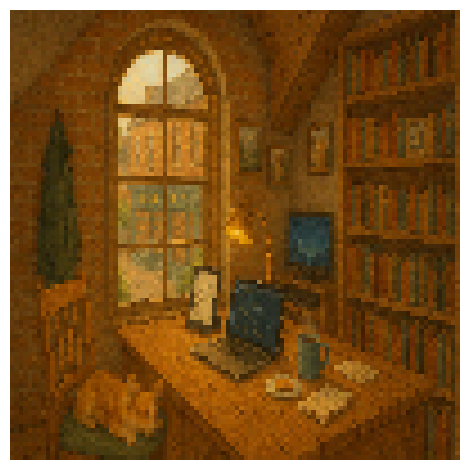

In [6]:
image_rgb = load_and_resize_image('ai_image.png', size=(100, 100))
plot_image(image_rgb)
pixels = image_rgb.reshape(-1, 3)

### KNN

In [7]:
kmeans = fit_kmeans(pixels, max_k=11, use_elbow=False)
kmeans_hex_codes = get_hex_codes_from_centers(kmeans.cluster_centers_)

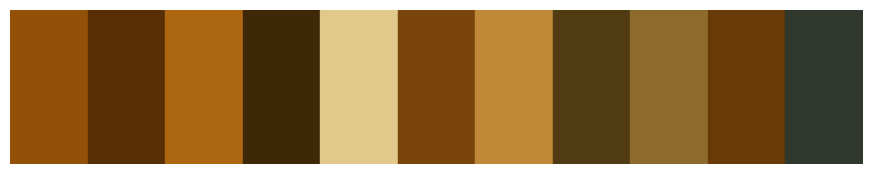

In [8]:
plot_color_swatch(kmeans_hex_codes)

### GMM

In [9]:
gmm = fit_gmm(pixels, max_k=20, use_bic=False)
hex_codes = get_hex_codes_from_gmm_means(gmm.means_)

In [12]:
hex_codes

['#9e5406',
 '#5f3306',
 '#98641d',
 '#412708',
 '#e0c88c',
 '#764108',
 '#b8893e',
 '#40330f',
 '#77652a',
 '#513810',
 '#2d342b',
 '#643d0e',
 '#bb7b26',
 '#8a4703',
 '#502a03',
 '#837037',
 '#7f4d10',
 '#6c3603',
 '#d28814',
 '#b16209']

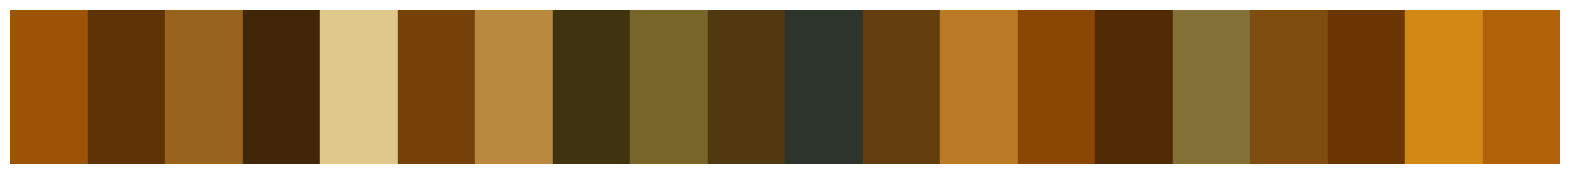

In [14]:
plot_color_swatch(hex_codes)

### Gradient

In [21]:
def hex_to_rgb_normalized(hex_color):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16) / 255
    g = int(hex_color[2:4], 16) / 255
    b = int(hex_color[4:6], 16) / 255
    return (r, g, b)

def rgb_normalized_to_hex(rgb_normalized):
    r = int(round(rgb_normalized[0] * 255))
    g = int(round(rgb_normalized[1] * 255))
    b = int(round(rgb_normalized[2] * 255))
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)



def hex_to_lab(hex_color):
    rgb = np.array(hex_to_rgb_normalized(hex_color)).reshape(1, 1, 3)
    lab = skcolor.rgb2lab(rgb)
    return lab[0, 0]


def delta_e(lab1, lab2):
    return np.linalg.norm(lab1 - lab2)


def interpolate_hsl_gradient(color1_hex, color2_hex, steps=10):
    
    rgb1 = hex_to_rgb_normalized(color1_hex)
    rgb2 = hex_to_rgb_normalized(color2_hex)
    
    h1, l1, s1 = colorsys.rgb_to_hls(*rgb1)
    h2, l2, s2 = colorsys.rgb_to_hls(*rgb2)
    
    if abs(h2 - h1) > 0.5:
        if h1 > h2:
            h2 += 1
        else:
            h1 += 1

    h_step = (h2 - h1) / (steps - 1)
    l_step = (l2 - l1) / (steps - 1)
    s_step = (s2 - s1) / (steps - 1)
    
    gradient = []
    
    for i in range(steps):
        h = (h1 + i * h_step) % 1.0
        l = l1 + i * l_step
        s = s1 + i * s_step
        
        rgb = colorsys.hls_to_rgb(h, l, s)
        hex_color = rgb_normalized_to_hex(rgb)
        gradient.append(hex_color)
    
    return gradient


def generate_full_hsl_gradient(palette, steps_per_transition=50, duplicate_threshold=5):
    """Expand palette by interpolating smooth HSL gradients between adjacent colors."""
    
    full_gradient = []
    n = len(palette)
    
    for i in range(n):
        color_start = palette[i]
        color_end = palette[(i + 1) % n]  # wrap around for full circle
        gradient = interpolate_hsl_gradient(color_start, color_end, steps=steps_per_transition)
        full_gradient.extend(gradient[:-1])  # skip last color to avoid duplication

    full_gradient = deduplicate_colors(full_gradient, duplicate_threshold)
    return full_gradient

def deduplicate_colors(colors, threshold=5):
    labs = [hex_to_lab(c) for c in colors]
    deduped_colors = colors.copy()
    
    i = 0
    while i < len(labs):
        j = i + 1
        while j < len(labs):
            if delta_e(labs[i], labs[j]) < threshold:
                # Remove the second color if too similar
                deduped_colors.pop(j)
                labs.pop(j)
            else:
                j += 1
        i += 1
    
    return deduped_colors

def sort_palette_by_closeness(colors):
    if not colors:
        return []
    
    labs = [hex_to_lab(c) for c in colors]
    used = [False] * len(colors)
    
    sorted_colors = []
    current_idx = 0
    sorted_colors.append(colors[current_idx])
    used[current_idx] = True
    
    for _ in range(len(colors) - 1):
        min_dist = float('inf')
        next_idx = None
        
        for j in range(len(colors)):
            if not used[j]:
                dist = delta_e(labs[current_idx], labs[j])
                if dist < min_dist:
                    min_dist = dist
                    next_idx = j
        
        sorted_colors.append(colors[next_idx])
        used[next_idx] = True
        current_idx = next_idx
    
    return sorted_colors

def plot_color_wheel_gradient(colors, inner_radius=0.5, ring_width=0.5, figsize=(8, 8)):
    colors = sort_palette_by_closeness(colors)
    total_steps = len(colors)
    angles = np.linspace(0, 2*np.pi, total_steps, endpoint=False)
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for angle, color in zip(angles, colors):
        ax.bar(angle, ring_width, width=2*np.pi/total_steps, bottom=inner_radius,
               color=color, edgecolor=None, linewidth=0)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()



In [74]:
def extract_palette_by_frequency_and_lab(image_path, resize_dim=(300, 300), min_pixel_count=150, delta_e_threshold=5, max_colors=None):

    image_rgb = load_and_resize_image(image_path, size=resize_dim)
    pixels = image_rgb.reshape(-1, 3)
    

    colors, counts = np.unique(pixels, axis=0, return_counts=True)

    sorted_indices = np.argsort(-counts)
    colors = colors[sorted_indices]
    counts = counts[sorted_indices]

    filtered_colors = [c for i, c in enumerate(colors) if counts[i] >= min_pixel_count]


    final_colors = []
    final_labs = []
    
    for rgb in filtered_colors:
        rgb_norm = np.array(rgb) / 255.0
        lab = skcolor.rgb2lab(rgb_norm.reshape(1, 1, 3))[0, 0]
        
        if not final_labs:
            final_colors.append(rgb)
            final_labs.append(lab)
        else:
            dists = np.linalg.norm(np.array(final_labs) - lab, axis=1)
            if np.all(dists > delta_e_threshold):
                final_colors.append(rgb)
                final_labs.append(lab)
        
        if max_colors and len(final_colors) >= max_colors:
            break

    hex_codes = ['#{:02x}{:02x}{:02x}'.format(*np.round(rgb).astype(int)) for rgb in final_colors]
    
    return hex_codes


In [78]:
temp =extract_palette_by_frequency_and_lab('swatch.png')

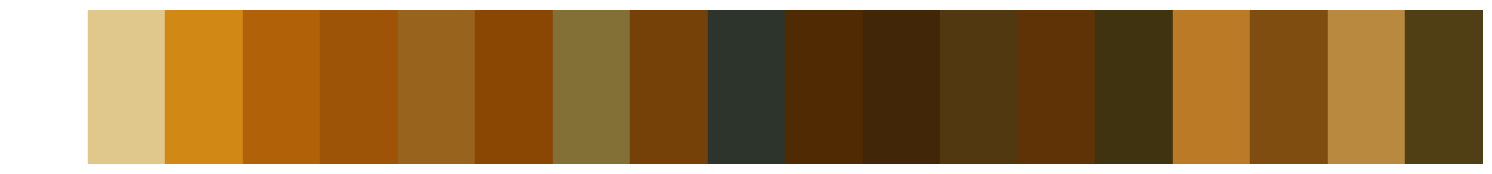

In [79]:
plot_color_swatch(temp)

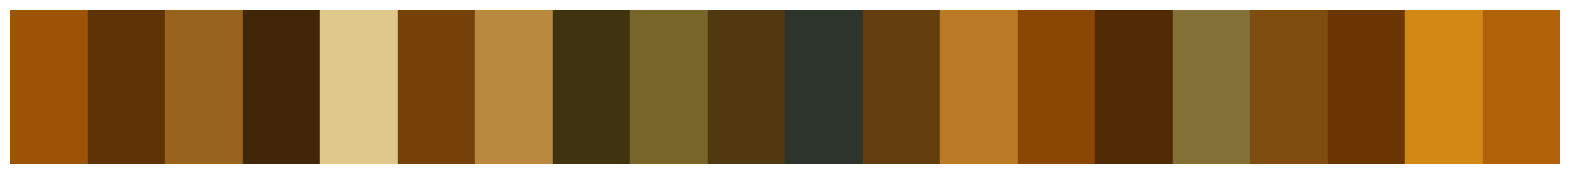

In [80]:
plot_color_swatch(hex_codes)

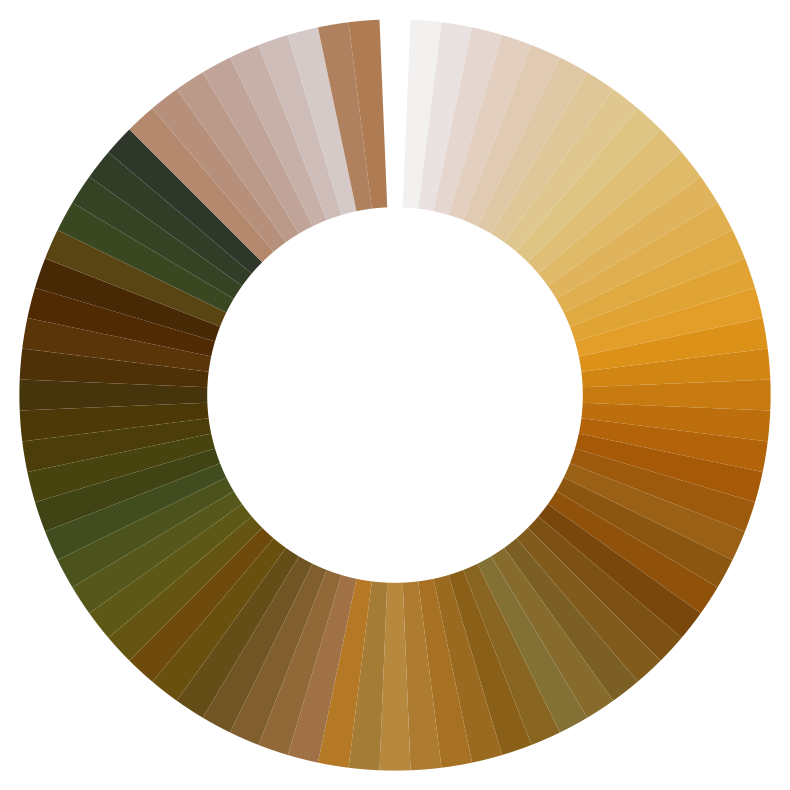

In [82]:
full_gradient = generate_full_hsl_gradient(temp, steps_per_transition=100)

# Step 2: Plot the gradient as a color wheel
plot_color_wheel_gradient(full_gradient)


In [ ]:
# def generate_palette_color_wheel(palette,steps_per_transition=50, duplicate_threshold=5, inner_radius=0.5, ring_width=0.5,figsize=(8,8),save_path=None):
    
#     # Step 1: Interpolate smooth gradient
#     full_gradient = generate_full_hsl_gradient(palette, steps_per_transition=steps_per_transition, duplicate_threshold=duplicate_threshold)
    
#     # Step 2: Sort by visual closeness
#     full_gradient = sort_palette_by_closeness(full_gradient)
    
#     # Step 3: Plot or save
#     total_steps = len(full_gradient)
#     angles = np.linspace(0, 2*np.pi, total_steps, endpoint=False)
    
#     fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
#     ax.set_theta_offset(np.pi / 2)
#     ax.set_theta_direction(-1)

#     for angle, color in zip(angles, full_gradient):
#         ax.bar(angle, ring_width, width=2*np.pi/total_steps, bottom=inner_radius,
#                color=color, edgecolor=None, linewidth=0)

#     ax.set_axis_off()
#     plt.tight_layout()

#     if save_path:
#         fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
#         plt.close(fig)
#     else:
#         plt.show()


In [90]:
def fit_gmm_to_colors(rgb_pixels, n_components=5):

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(rgb_pixels)
    
    centroids = gmm.means_  # shape (n_components, 3)
    soft_probs = gmm.predict_proba(rgb_pixels)  # shape (num_pixels, n_components)
    
    return centroids, soft_probs

def soft_blend_pixel(centroids, soft_probs):
    """Blend RGB centroids according to soft probabilities for a single pixel."""
    blended_rgb = np.average(centroids, axis=0, weights=soft_probs)
    return blended_rgb


In [93]:
def generate_soft_gmm_color_wheel(image_path,n_components=5, sample_size=5000, steps_per_transition=30, deduplication_threshold=5,figsize=(8,8),save_path=None):


    image_rgb = load_and_resize_image(image_path, size=(100, 100))
    pixels = image_rgb.reshape(-1, 3)

    if len(pixels) > sample_size:
        idx = np.random.choice(len(pixels), size=sample_size, replace=False)
        pixels = pixels[idx]
    

    centroids, soft_probs = fit_gmm_to_colors(pixels, n_components)
  
    blended_colors_rgb = []
    for pixel_probs in soft_probs:
        blended_rgb = soft_blend_pixel(centroids, pixel_probs)
        blended_colors_rgb.append(blended_rgb)

    blended_colors_hex = [rgb_normalized_to_hex(rgb / 255) for rgb in blended_colors_rgb]
    

    deduped_colors = deduplicate_colors(blended_colors_hex, threshold=deduplication_threshold)
    

    sorted_colors = sort_palette_by_closeness(deduped_colors)
    
    full_gradient = generate_full_hsl_gradient(sorted_colors, steps_per_transition=steps_per_transition)
    
    plot_color_wheel_gradient(full_gradient, figsize=figsize)


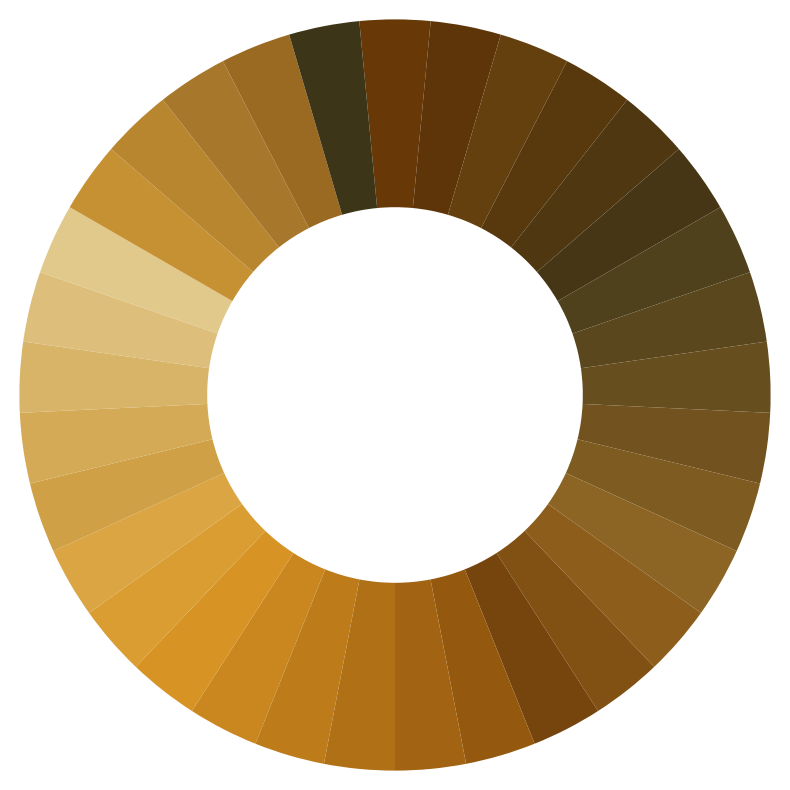

In [94]:
generate_soft_gmm_color_wheel('ai_image.png')

In [95]:
def generate_opposite_palette(hex_palette):
    opposite_palette = []
    for hex_color in hex_palette:
        r, g, b = hex_to_rgb_normalized(hex_color)
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        h_opp = (h + 0.5) % 1.0
        r_opp, g_opp, b_opp = colorsys.hls_to_rgb(h_opp, l, s)
        hex_opp = rgb_normalized_to_hex((r_opp, g_opp, b_opp))
        opposite_palette.append(hex_opp)
    return opposite_palette


In [96]:
opp_palette = generate_opposite_palette(hex_codes)

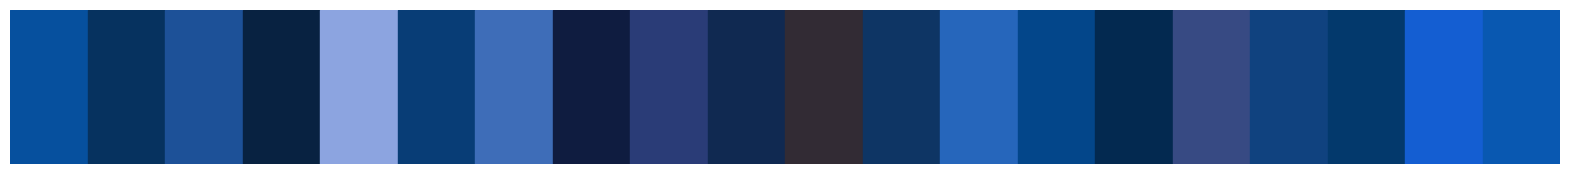

In [97]:
plot_color_swatch(opp_palette)